# Reading the ROOT files

In [418]:
# %matplotlib notebook

In [1]:
import uproot
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import awkward as ak

In [268]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, svm
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
%matplotlib inline

In [4]:
from scipy.ndimage import median as med

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
import IPython
from matplotlib import cm

In [6]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [507]:
fastn = uproot.open('data/fastn2.root'+':data')
sing = uproot.open('data/singles.root'+':data')
eplus = uproot.open('data/e+.root'+':data')
eminus = uproot.open('data/e-.root'+':data')
fastnsing = uproot.open('data/fastn_singles.root'+':data')

In [508]:
neutrons = fastn.arrays(library='awkward')
singles = sing.arrays(library='awkward')#[:20000]
positrons = eplus.arrays(library='awkward')#[:20000]
electrons = eminus.arrays(library='awkward')
# singles['channel']=singles['channel']-1 #need to reprocess..

In [509]:
neutrons

<Array [{gtid: 1, ... average_like_05m: -69.8}] type='23509 * {"gtid": int32, "m...'>

In [398]:
nsing = fastnsing.arrays(library='awkward')
moresingles = nsing[nsing['code']==4]
moreneutrons = nsing[nsing['code']==2]

In [399]:
singles = ak.concatenate([singles, moresingles])
neutrons = ak.concatenate([neutrons, moreneutrons])

In [510]:
# Time-sort all the data arrays for recurrent/sequential purposes. 
for j, data in enumerate([neutrons, singles, positrons]):
    print('set %i of %i'%(j+1, 3))
    args = ak.argsort(data['hittime'])
    for key in ['hittime', 'pmtcharge', 'channel']:
        data[key] = data[key][args]
    data = data[data['gtid']>2]

set 1 of 3
set 2 of 3
set 3 of 3


In [514]:
neutrons = neutrons[neutrons['inner_hit']>0]

In [515]:
neutrons

<Array [{gtid: 3, mcid: 161, ... 649]}] type='21433 * {"gtid": int32, "mcid": in...'>

In [154]:
data = singles

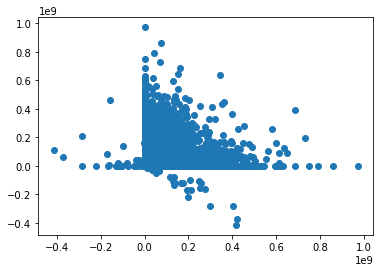

In [260]:
plt.scatter(neutrons['dt_prev_us'], neutrons['dt_next_us'],
#          bins=np.linspace(0, 1e9, 60), 
#          histtype='step',
           )
plt.show()

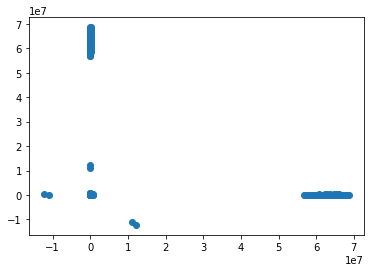

In [261]:
plt.scatter(singles['dt_prev_us'], singles['dt_next_us'],
#          bins=np.linspace(0, 1e9, 60), 
#          histtype='step',
           )
plt.show()

## Random Forests

In [183]:
dimensions = [
    'n9', # 'n9_prev', # 'n9_next',
    'x', 'y', 'z',  # 't',
    'id_plus_dr_hit', # 'inner_hit_prev', # 'inner_hit_next',
    'good_dir', #'good_dir_prev', 
    'good_pos',# 'good_pos_prev', 
#     'distpmt', 
    'closestPMT', #'closestPMT_prev', #'closestPMT_next', 
  #  'drPrevr', #'dzPrevz',
#     'dt_prev_us', 
    'azimuth_ks', 
    
]

In [184]:
def calcr(data):
    data['r'] = np.sqrt(data['x']**2+data['y']**2)
    return data

In [185]:
def get_dims(data, dimensions=dimensions):
    df_cut = data[dimensions]
    print('Remaining variables selected for analysis: %i'%(len(dimensions)))
    return df_cut

In [186]:
samples = np.min([len(singles), len(positrons)])

In [187]:
sing = get_dims(singles, dimensions=dimensions)[:samples]
eplus = get_dims(positrons, dimensions=dimensions)[:samples]

Remaining variables selected for analysis: 9
Remaining variables selected for analysis: 9


In [188]:
y = np.zeros(len(sing))
y = np.append(y, np.ones(len(eplus)))

In [189]:
x = pd.concat([ak.to_pandas(sing), ak.to_pandas(eplus)])

In [190]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25) 

In [191]:
X_save = X_test

In [192]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [193]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, max_depth=6)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_test_pred=clf.predict(X_test)

In [194]:
y_test_prob = clf.predict_proba(X_test)

In [195]:
# Model Accuracy, how often is the classifier correct?
print("Train Accuracy: %.2f%%"%(metrics.accuracy_score(y_train, y_train_pred)*100))
print("Test Accuracy: %.2f%%"%(metrics.accuracy_score(y_test, y_test_pred)*100))

Train Accuracy: 99.86%
Test Accuracy: 99.84%


In [196]:
feature_imp = pd.Series(clf.feature_importances_,index=dimensions).sort_values(ascending=False)

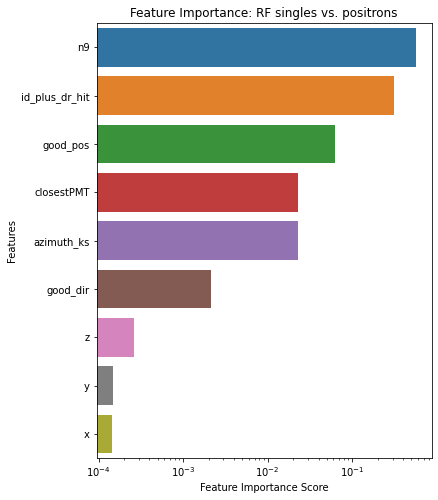

In [197]:
# Creating a bar plot
plt.figure(figsize=(6, 8))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.xscale('log')
plt.ylabel('Features')
plt.title("Feature Importance: RF singles vs. positrons")
# plt.legend()
plt.show()

In [179]:
scores = y_test_prob[:,1]

In [180]:
fpr, tpr, thresholds = roc_curve(y_test, scores)
auc = roc_auc_score(y_test, scores)

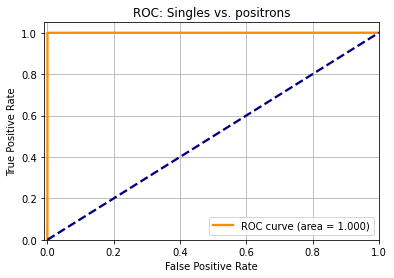

In [198]:
plt.plot(fpr, tpr, 
         label='ROC curve (area = %0.3f)'%(auc), 
         color='darkorange', 
         lw=2.3, 
        )
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Singles vs. positrons')
plt.plot([0, 1], [0, 1], color='navy', lw=2.3, linestyle='--')
plt.legend()
plt.grid()
# plt.xlim([1e-6, 1.0])
# plt.ylim([1e-2, 1.05])
# plt.xscale('log')
# plt.yscale('log')
plt.show()

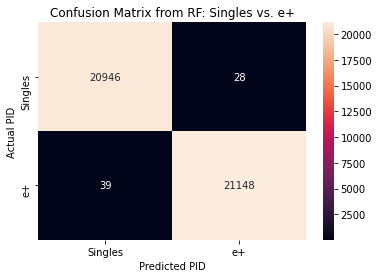

In [199]:
confmat = metrics.confusion_matrix(y_test, y_test_pred)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
#                  norm=LogNorm()
                )

ax.set_title('Confusion Matrix from RF: Singles vs. e+')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['Singles', 'e+'])
ax.yaxis.set_ticklabels(['Singles', 'e+'])

plt.show()

In [200]:
wrong = X_save[y_test_pred!=y_test]

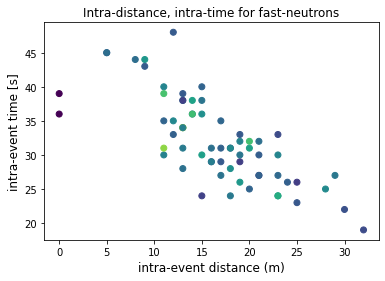

In [201]:
plt.scatter(wrong['n9'], wrong['id_plus_dr_hit'], c=wrong['azimuth_ks']
#             c=wrong['sub_id']
          )
# plt.xlim(1e-1,1e2)
# plt.ylim(1e-7, 1e3)
# plt.colorbar(label='events/bin')
plt.xlabel('intra-event distance (m)', fontsize=12)
plt.ylabel('intra-event time [s]', fontsize=12)
# plt.xscale('log')
# plt.yscale('log')
# plt.grid()
plt.title('Intra-distance, intra-time for fast-neutrons')
plt.show()

## Positrons vs. neutrons 

In [468]:
dimensions = [
    'n9', # 'n9_prev', # 'n9_next',
    'x', 'y', 'z',  # 't',
    'id_plus_dr_hit', # 'inner_hit_prev', # 'inner_hit_next',
    'good_dir', #'good_dir_prev', 
    'good_pos',# 'good_pos_prev', 
#     'distpmt', 
    'closestPMT', #'closestPMT_prev', #'closestPMT_next', 
  #  'drPrevr', #'dzPrevz',
#     'dt_prev_us', 
    'azimuth_ks', 
    
]

In [469]:
samples = np.min([len(neutrons), len(positrons)])

In [470]:
eplus = get_dims(positrons, dimensions=dimensions)[:samples]
n = get_dims(neutrons, dimensions=dimensions)[:samples]

Remaining variables selected for analysis: 9
Remaining variables selected for analysis: 9


In [471]:
y = np.zeros(len(eplus))
y = np.append(y, np.ones(len(n)))

In [472]:
x = pd.concat([ak.to_pandas(eplus), ak.to_pandas(n)])

In [473]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25) 

In [475]:
X_save = X_test

In [476]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [477]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, max_depth=6)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_test_pred=clf.predict(X_test)

In [478]:
y_test_prob = clf.predict_proba(X_test)

In [479]:
# Model Accuracy, how often is the classifier correct?
print("Train Accuracy: %.2f%%"%(metrics.accuracy_score(y_train, y_train_pred)*100))
print("Test Accuracy: %.2f%%"%(metrics.accuracy_score(y_test, y_test_pred)*100))

Train Accuracy: 85.74%
Test Accuracy: 85.54%


In [480]:
feature_imp = pd.Series(clf.feature_importances_,index=dimensions).sort_values(ascending=False)

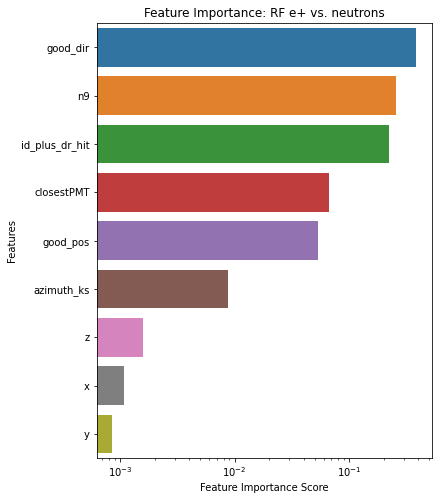

In [481]:
# Creating a bar plot
plt.figure(figsize=(6, 8))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.xscale('log')
plt.ylabel('Features')
plt.title("Feature Importance: RF e+ vs. neutrons")
# plt.legend()
plt.show()

In [482]:
scores = y_test_prob[:,1]

In [483]:
fpr, tpr, thresholds = roc_curve(y_test, scores)
auc = roc_auc_score(y_test, scores)

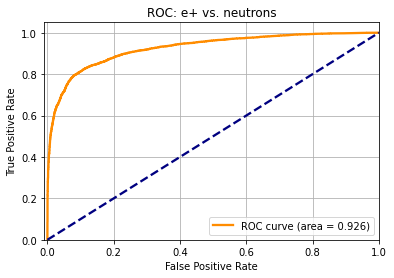

In [484]:
plt.plot(fpr, tpr, 
         label='ROC curve (area = %0.3f)'%(auc), 
         color='darkorange', 
         lw=2.3, 
        )
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: e+ vs. neutrons')
plt.plot([0, 1], [0, 1], color='navy', lw=2.3, linestyle='--')
plt.legend()
plt.grid()
# plt.xlim([1e-6, 1.0])
# plt.ylim([1e-2, 1.05])
# plt.xscale('log')
# plt.yscale('log')
plt.show()

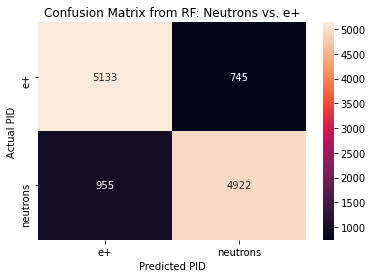

In [485]:
confmat = metrics.confusion_matrix(y_test, y_test_pred)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
#                  norm=LogNorm()
                )

ax.set_title('Confusion Matrix from RF: Neutrons vs. e+')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['e+', 'neutrons'])
ax.yaxis.set_ticklabels(['e+', 'neutrons'])

plt.show()

In [486]:
wrong = X_save[y_test_pred!=y_test]

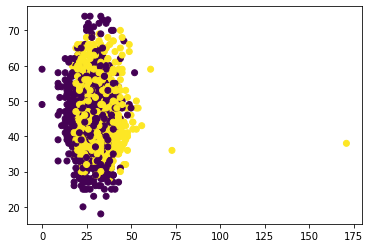

In [487]:
plt.scatter(wrong['n9'], wrong['id_plus_dr_hit'], c=y_test[y_test_pred!=y_test]
#             c=wrong['sub_id']
          )
# plt.xlim(1e-1,1e2)
# plt.ylim(1e-7, 1e3)
# plt.colorbar(label='events/bin')
# plt.xlabel('intra-event distance (m)', fontsize=12)
# plt.ylabel('intra-event time [s]', fontsize=12)
# plt.xscale('log')
# plt.yscale('log')
# plt.grid()
# plt.title('Intra-distance, intra-time for fast-neutrons')
plt.show()

## Neutrons vs. singles 

Goal: IF we can isolate singles from all else, we can use info-previous w/ our high-stats. 

In [516]:
dimensions = [
    'n9', # 'n9_prev', # 'n9_next',
    'x', 'y', 'z',  # 't',
    'id_plus_dr_hit', # 'inner_hit_prev', # 'inner_hit_next',
    'good_dir', #'good_dir_prev', 
    'good_pos',# 'good_pos_prev', 
#     'distpmt', 
    'closestPMT', #'closestPMT_prev', #'closestPMT_next', 
  #  'drPrevr', #'dzPrevz',
#     'dt_prev_us', 
    'azimuth_ks', 
    
]

In [517]:
samples = np.min([len(neutrons), len(singles)])

In [518]:
sing = get_dims(singles, dimensions=dimensions)[:samples]
n = get_dims(neutrons, dimensions=dimensions)[:samples]

Remaining variables selected for analysis: 9
Remaining variables selected for analysis: 9


In [519]:
y = np.zeros(len(sing))
y = np.append(y, np.ones(len(n)))

In [520]:
x = pd.concat([ak.to_pandas(sing), ak.to_pandas(n)])

In [521]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25) 

In [522]:
X_save = X_test

In [523]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [524]:
clf = svm.SVC()

In [525]:
clf=RandomForestClassifier(n_estimators=100, max_depth=6)

In [526]:
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_test_pred=clf.predict(X_test)

In [527]:
y_test_prob = clf.predict_proba(X_test)

In [528]:
# Model Accuracy, how often is the classifier correct?
print("Train Accuracy: %.2f%%"%(metrics.accuracy_score(y_train, y_train_pred)*100))
print("Test Accuracy: %.2f%%"%(metrics.accuracy_score(y_test, y_test_pred)*100))

Train Accuracy: 96.97%
Test Accuracy: 96.67%


In [529]:
feature_imp = pd.Series(clf.feature_importances_,index=dimensions).sort_values(ascending=False)

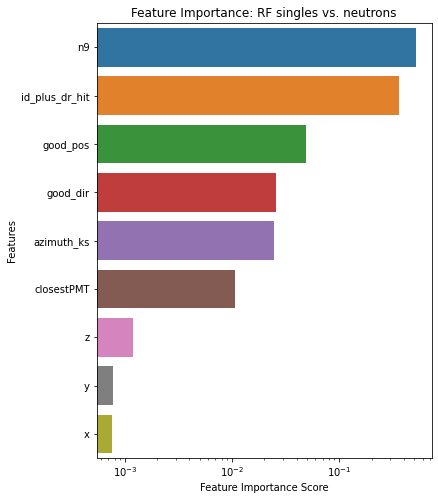

In [530]:
# Creating a bar plot
plt.figure(figsize=(6, 8))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.xscale('log')
plt.ylabel('Features')
plt.title("Feature Importance: RF singles vs. neutrons")
# plt.legend()
plt.show()

In [534]:
scores = y_test_prob[:,1]

In [535]:
fpr, tpr, thresholds = roc_curve(y_test, scores)
auc = roc_auc_score(y_test, scores)

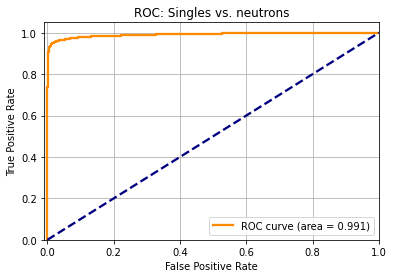

In [536]:
plt.plot(fpr, tpr, 
         label='ROC curve (area = %0.3f)'%(auc), 
         color='darkorange', 
         lw=2.3, 
        )
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Singles vs. neutrons')
plt.plot([0, 1], [0, 1], color='navy', lw=2.3, linestyle='--')
plt.legend()
plt.grid()
# plt.xlim([1e-6, 1.0])
# plt.ylim([1e-2, 1.05])
# plt.xscale('log')
# plt.yscale('log')
plt.show()

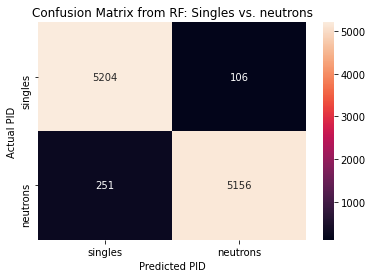

In [537]:
confmat = metrics.confusion_matrix(y_test, y_test_pred)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
#                  norm=LogNorm()
                )

ax.set_title('Confusion Matrix from RF: Singles vs. neutrons')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['singles', 'neutrons'])
ax.yaxis.set_ticklabels(['singles', 'neutrons'])

plt.show()

In [538]:
wrong = X_save[y_test_pred!=y_test]

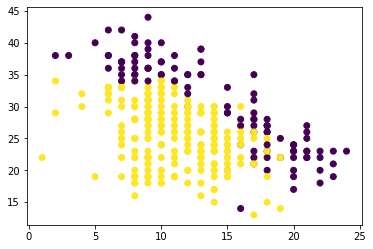

In [539]:
plt.scatter(wrong['n9'], wrong['id_plus_dr_hit'], c=y_test[y_test_pred!=y_test]
#             c=wrong['sub_id']
          )
# plt.xlim(1e-1,1e2)
# plt.ylim(1e-7, 1e3)
# plt.colorbar(label='events/bin')
# plt.xlabel('intra-event distance (m)', fontsize=12)
# plt.ylabel('intra-event time [s]', fontsize=12)
# plt.xscale('log')
# plt.yscale('log')
# plt.grid()
# plt.title('Intra-distance, intra-time for fast-neutrons')
plt.show()

## 3-class RF

In [540]:
dimensions = [
    'n9', # 'n9_prev', # 'n9_next',
    'x', 'y', 'z',  # 't',
    'id_plus_dr_hit', # 'inner_hit_prev', # 'inner_hit_next',
    'good_dir', #'good_dir_prev', 
    'good_pos',# 'good_pos_prev', 
#     'distpmt', 
    'closestPMT', #'closestPMT_prev', #'closestPMT_next', 
  #  'drPrevr', #'dzPrevz',
#     'dt_prev_us', 
    'azimuth_ks', 
    
]

In [541]:
samples = np.min([len(neutrons), len(positrons), len(singles)])

In [558]:
eplus = get_dims(positrons, dimensions=dimensions)[:samples]
n = get_dims(neutrons, dimensions=dimensions)[:samples]
sing = get_dims(singles, dimensions=dimensions)[:samples]

Remaining variables selected for analysis: 9
Remaining variables selected for analysis: 9
Remaining variables selected for analysis: 9


In [560]:
y = np.zeros(len(sing))
y = np.append(y, np.ones(len(eplus)))
y = np.append(y, np.ones(len(neutrons))*2)


In [561]:
x = pd.concat([ak.to_pandas(sing), ak.to_pandas(eplus), ak.to_pandas(n)])

In [562]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25) 

In [563]:
X_save = X_test

In [564]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [580]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100, max_depth=8)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_test_pred=clf.predict(X_test)

In [578]:
y_test_prob = clf.predict_proba(X_test)

In [579]:
# Model Accuracy, how often is the classifier correct?
print("Train Accuracy: %.2f%%"%(metrics.accuracy_score(y_train, y_train_pred)*100))
print("Test Accuracy: %.2f%%"%(metrics.accuracy_score(y_test, y_test_pred)*100))

Train Accuracy: 89.83%
Test Accuracy: 88.52%


In [568]:
feature_imp = pd.Series(clf.feature_importances_,index=dimensions).sort_values(ascending=False)

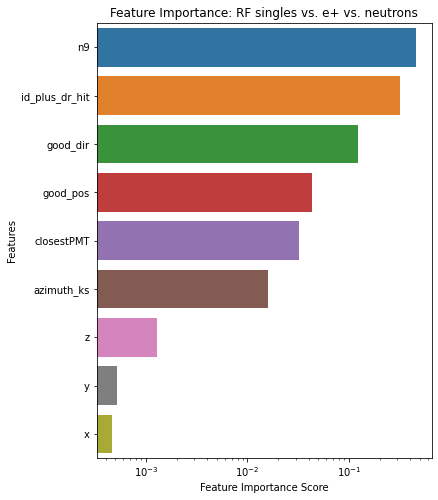

In [569]:
# Creating a bar plot
plt.figure(figsize=(6, 8))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.xscale('log')
plt.ylabel('Features')
plt.title("Feature Importance: RF singles vs. e+ vs. neutrons")
# plt.legend()
plt.show()

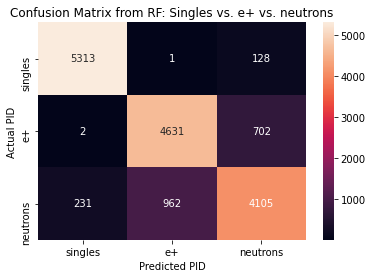

In [570]:
confmat = metrics.confusion_matrix(y_test, y_test_pred)
ax = sns.heatmap(confmat, annot=True, fmt='g', 
#                  norm=LogNorm()
                )

ax.set_title('Confusion Matrix from RF: Singles vs. e+ vs. neutrons')
ax.set_xlabel('Predicted PID')
ax.set_ylabel('Actual PID')

ax.xaxis.set_ticklabels(['singles', 'e+', 'neutrons'])
ax.yaxis.set_ticklabels(['singles', 'e+', 'neutrons'])

plt.show()

In [571]:
prob_01 = y_test_prob[:,1][y_test!=2]
prob_02 = y_test_prob[:,2][y_test!=1]
prob_12 = y_test_prob[:,2][y_test!=0]

In [572]:
fpr, tpr, thresholds = roc_curve(y_test[y_test!=1]-1, prob_02)

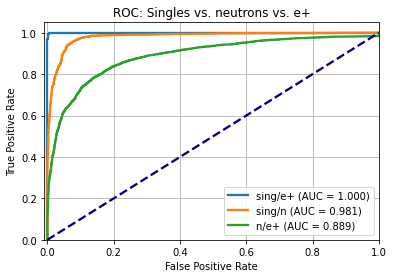

In [573]:
plt.figure()
for i, prob, label in zip([2, 1, 0], 
                          [prob_01, prob_02, prob_12], 
                          ['sing/e+', 'sing/n', 'n/e+']
                         ):
    if i==2:
        fpr, tpr, thresholds = roc_curve(y_test[y_test!=i], prob)
    else:
        fpr, tpr, thresholds = roc_curve(y_test[y_test!=i]-1, prob)
        
    auc = roc_auc_score(y_test[y_test!=i], prob)
    plt.plot(fpr, tpr, 
         label='%s (AUC = %0.3f)'%(label, auc), 
#          color='darkorange', 
         lw=2.3, 
        )
plt.xlim([-0.01, 1.0])
plt.ylim([0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC: Singles vs. neutrons vs. e+')
plt.plot([0, 1], [0, 1], color='navy', lw=2.3, linestyle='--')
plt.legend()
plt.grid()
plt.show()

In [584]:
kw = dict(bins=np.linspace(0,1,50), histtype='step', density=True)

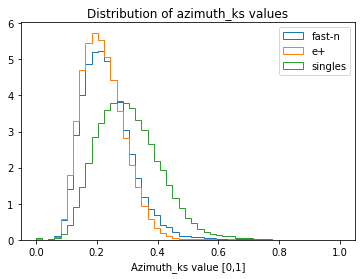

In [590]:
plt.hist(neutrons['azimuth_ks'], label='fast-n', **kw)
plt.hist(positrons['azimuth_ks'], label='e+', **kw)
plt.hist(singles['azimuth_ks'], label='singles', **kw)
plt.xlabel('Azimuth_ks value [0,1]')
plt.legend()
plt.title('Distribution of azimuth_ks values')
plt.show()